In [105]:
import numpy as np
import pandas as pd
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
from datetime import datetime,date

%matplotlib inline
init_notebook_mode(connected=True)
cf.set_config_file(sharing='private',theme='pearl',offline=True)
#print("Cufflinks Version : {}".format(cf.__version__))

df = pd.read_csv('./data/btc-usd-max.csv',index_col=0,parse_dates=True )
df = df.resample('D').first()
df.drop(["market_cap", "total_volume"], axis=1, inplace=True)
df['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])
df2 = pd.read_csv('./data/eth-usd-max.csv',index_col=0,parse_dates=True )
df2.drop(["market_cap", "total_volume"], axis=1, inplace=True)
df2 = df2.resample('D').first()
df2['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])

In [106]:
def first_day(entry):
    """
    Returns the first instance of the period, regardless of sampling rate.
    """
    if len(entry):  # handles the case of missing data
        return entry[0]

In [107]:
# here i will use monthly data
df= df.resample(rule='MS').apply(first_day)

In [108]:
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:xlabel='snapped_at'>

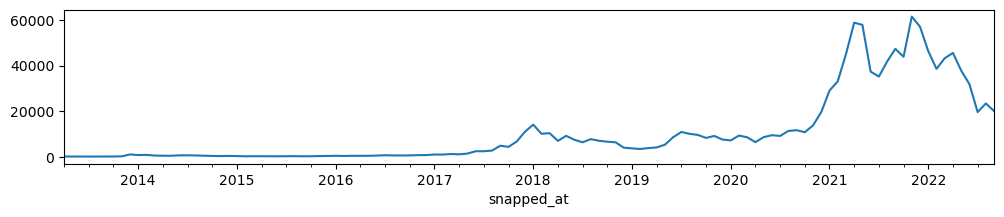

In [109]:
results = seasonal_decompose(df['price'])
results.observed.plot(figsize=(12,2))

<AxesSubplot:xlabel='snapped_at'>

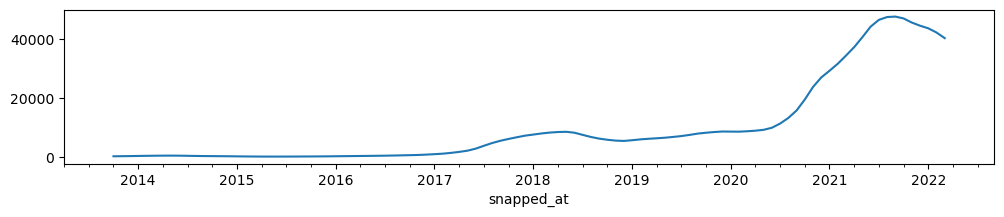

In [110]:
results.trend.plot(figsize=(12,2))

<AxesSubplot:xlabel='snapped_at'>

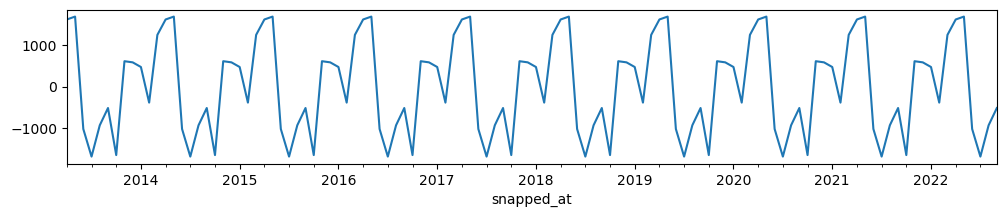

In [111]:
results.seasonal.plot(figsize=(12,2))

In [112]:
len(df)

114

In [113]:
train = df

In [114]:
from sklearn.preprocessing import MinMaxScaler

In [115]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [116]:
# we do this just on the training data as in real life we have no idea of the actual datra to fit for the test set
scaler.fit(train) # finds the max value in the training set

MinMaxScaler()

In [117]:
# transform the training and test data via the scaler object above. MinMaxscaler doesnt simply divide 
# by athe max or min value... it uses more complex method
scaled_train = scaler.transform(train)

In [118]:
# now everything is scaled we need to createa timeseries generator to feed the neural network
from keras.preprocessing.sequence import TimeseriesGenerator

In [119]:
# Redefine to get 12 months back and then predict the next month out
n_input = 12
n_features = 1 # for time series it is 1 as we have one output the prediction (one column of data)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [120]:
# Create the model , train it and test it
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [121]:
# define model
model = Sequential()
# 100 is the number of neurons. we play around to find a good number and you play around
model.add(LSTM(500, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [122]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 500)               1004000   
                                                                 
 dense_3 (Dense)             (None, 1)                 501       
                                                                 
Total params: 1,004,501
Trainable params: 1,004,501
Non-trainable params: 0
_________________________________________________________________


In [123]:
# 1 epoch is a single run through all our data
model.fit(generator,epochs=200)

Epoch 1/200
102/102 [==============================] - 2s 14ms/step - loss: 0.0337
Epoch 2/200
102/102 [==============================] - 1s 14ms/step - loss: 0.0195
Epoch 3/200
102/102 [==============================] - 3s 26ms/step - loss: 0.0230
Epoch 4/200
102/102 [==============================] - 4s 38ms/step - loss: 0.0155
Epoch 5/200
102/102 [==============================] - 3s 30ms/step - loss: 0.0118
Epoch 6/200
102/102 [==============================] - 3s 27ms/step - loss: 0.0125
Epoch 7/200
102/102 [==============================] - 3s 28ms/step - loss: 0.0160
Epoch 8/200
102/102 [==============================] - 3s 28ms/step - loss: 0.0109
Epoch 9/200
102/102 [==============================] - 3s 29ms/step - loss: 0.0097
Epoch 10/200
102/102 [==============================] - 3s 25ms/step - loss: 0.0102
Epoch 11/200
102/102 [==============================] - 3s 25ms/step - loss: 0.0105
Epoch 12/200
102/102 [==============================] - 2s 24ms/step - loss: 0.0087
E

102/102 [==============================] - 5s 45ms/step - loss: 9.9530e-04
Epoch 99/200
102/102 [==============================] - 3s 33ms/step - loss: 8.3701e-04
Epoch 100/200
102/102 [==============================] - 3s 28ms/step - loss: 7.2481e-04
Epoch 101/200
102/102 [==============================] - 3s 28ms/step - loss: 9.5466e-04
Epoch 102/200
102/102 [==============================] - 3s 25ms/step - loss: 0.0013
Epoch 103/200
102/102 [==============================] - 2s 24ms/step - loss: 0.0012
Epoch 104/200
102/102 [==============================] - 3s 29ms/step - loss: 0.0012
Epoch 105/200
102/102 [==============================] - 3s 32ms/step - loss: 0.0026
Epoch 106/200
102/102 [==============================] - 3s 26ms/step - loss: 0.0029
Epoch 107/200
102/102 [==============================] - 3s 26ms/step - loss: 0.0014
Epoch 108/200
102/102 [==============================] - 2s 23ms/step - loss: 0.0012
Epoch 109/200
102/102 [==============================] - 2s 24ms

102/102 [==============================] - 2s 23ms/step - loss: 3.7568e-04
Epoch 192/200
102/102 [==============================] - 3s 27ms/step - loss: 3.7289e-04
Epoch 193/200
102/102 [==============================] - 3s 25ms/step - loss: 3.7216e-04
Epoch 194/200
102/102 [==============================] - 3s 25ms/step - loss: 5.4171e-04
Epoch 195/200
102/102 [==============================] - 3s 25ms/step - loss: 0.0013
Epoch 196/200
102/102 [==============================] - 2s 23ms/step - loss: 0.0044
Epoch 197/200
102/102 [==============================] - 2s 22ms/step - loss: 0.0034
Epoch 198/200
102/102 [==============================] - 3s 27ms/step - loss: 0.0013
Epoch 199/200
102/102 [==============================] - 3s 26ms/step - loss: 6.6821e-04
Epoch 200/200
102/102 [==============================] - 2s 23ms/step - loss: 5.0353e-04


In [124]:
model.history.history.keys()

dict_keys(['loss'])

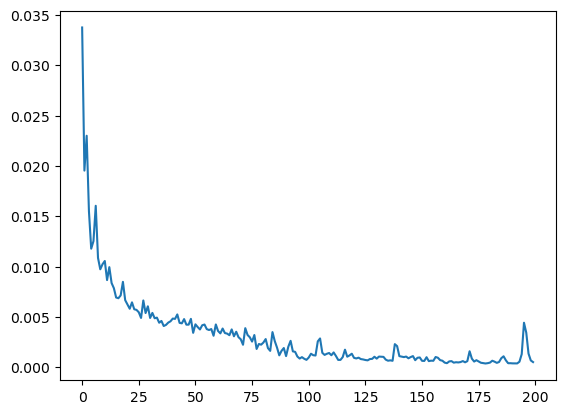

In [125]:
import matplotlib.pyplot as plt
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [126]:
# our model takes the last 12 history steps and predicts the next one 
first_eval_batch = scaled_train[-12:]

In [127]:
# in order to actually forecast into the future
test_predictions = [] # holding the predictions as we go along

# Last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
# we use the predicted points to predict further and further into the future 
# so RNN cannot work very well far into the future
# in order to predict into the future we can change the range for example len(test)+6 to forecast another 6 months
# or we can use the actual df2 to train and freely forecast into the future!
for i in range(12):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [128]:
# Inverse Transformations and Compare
true_predictions = scaler.inverse_transform(test_predictions)

In [129]:
true_predictions

array([[17136.03298793],
       [16152.28889001],
       [14173.20786727],
       [11810.89502123],
       [ 9558.58142112],
       [ 7605.89977841],
       [ 6238.64674876],
       [ 4528.90918251],
       [ 3329.95242923],
       [ 2505.06965985],
       [ 1455.12819737],
       [ 1098.61630364]])

In [130]:
# to add an extra period
# predictionsIndex = pd.date_range(pd.to_datetime(df.index[len(df2)-1])+pd.DateOffset(months=1), periods=12, freq='M')
predictionsIndex = pd.date_range(pd.to_datetime(df.index[len(df)-1]), periods=12, freq='MS')
predictions = pd.DataFrame(true_predictions,index=predictionsIndex, columns=['Prediction'])
predictions

,Prediction
2022-09-01 00:00:00+00:00,17136.032988
2022-10-01 00:00:00+00:00,16152.288890
2022-11-01 00:00:00+00:00,14173.207867
2022-12-01 00:00:00+00:00,11810.895021
2023-01-01 00:00:00+00:00,9558.581421
2023-02-01 00:00:00+00:00,7605.899778
2023-03-01 00:00:00+00:00,6238.646749
2023-04-01 00:00:00+00:00,4528.909183
2023-05-01 00:00:00+00:00,3329.952429
2023-06-01 00:00:00+00:00,2505.069660


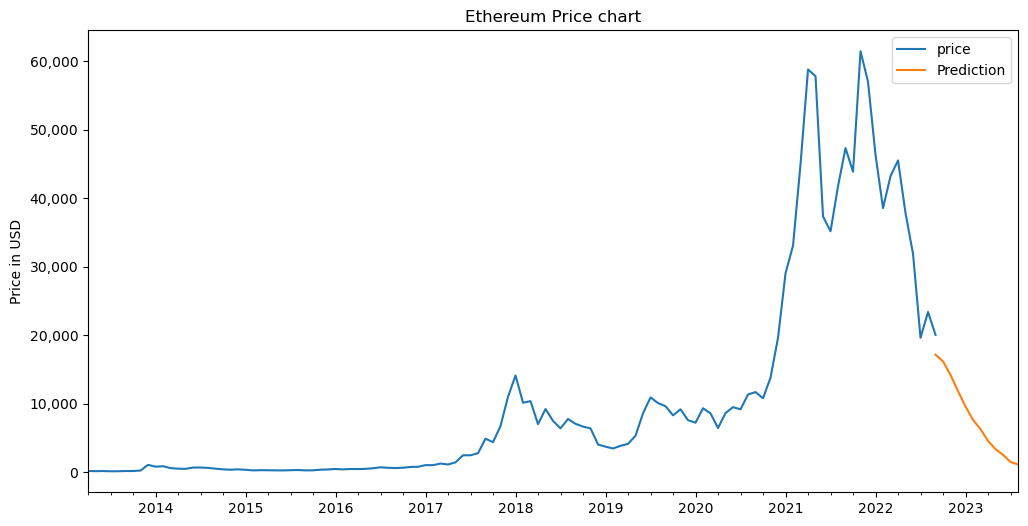

In [131]:
# Plot predictions against known values
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Ethereum Price chart'
ylabel='Price in USD'
xlabel='' # we don't really need a label here

ax = df['price'].plot(legend=True,figsize=(12,6),title=title)
predictions['Prediction'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [132]:
# same plot as above but with plotly
result = df.join(predictions['Prediction'], how='outer')
result[['price','Prediction']].iplot()

In [133]:
# in order not to retrain every time we can save the model
model.save('BTC_rnn_model.h5')

In [134]:
# and in order to reload 
# from keras.models import load_model
# model = load_model('BTC_rnn_model.h5')
# model.summary()